## Feed forward neural network

In [36]:
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

'/device:GPU:0'

In [40]:
if device_list != '/device:GPU:0':
  raise SystemError("GPU device not found")
print("found GPY at: {}". format(device_list))

found GPY at: /device:GPU:0


In [41]:
%%capture 
!pip install netCDF4

In [43]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import matplotlib.pyplot as plt
import numpy as np
from subprocess import call
import warnings
import pandas as pd

warnings.filterwarnings("ignore")  # specify to ignore warning messages
from keras.optimizers import SGD
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from pandas import DataFrame
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers.core import Lambda
from keras import backend as K
from netCDF4 import Dataset
from netCDF4 import getlibversion
from keras.models import load_model

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load dataset

In [45]:
%cd /content/drive/MyDrive/randomforest

# Load in data to a pandas dataframe
df = pd.read_pickle('input_microstructure.pkl')
df.reset_index(drop=True, inplace=True)

df

/content/drive/MyDrive/randomforest


,T,S,z,gamma,dTdz,dSdz,lat,lon,log_eps,log_kappa,log_N2_sort,hab,depth,cruise,profile
0,0.594316,34.733891,-3835.0,28.214811,0.002297,0.000235,-25.002001,-38.185333,-10.260384,-5.217481,-5.741873,93.0,-3928.0,1,0
1,0.621936,34.736645,-3825.0,28.212467,0.002297,0.000235,-25.002001,-38.185333,-10.004366,-4.961463,-5.741873,103.0,-3928.0,1,0
2,0.640263,34.738594,-3815.0,28.211014,0.001747,0.000191,-25.002001,-38.185333,-9.833233,-4.638316,-5.893887,113.0,-3928.0,1,0
3,0.656876,34.740475,-3805.0,28.209791,0.001718,0.000172,-25.002001,-38.185333,-10.048473,-4.886051,-5.861392,123.0,-3928.0,1,0
4,0.674622,34.742039,-3795.0,28.208130,0.002518,0.000253,-25.002001,-38.185333,-9.185361,-4.187189,-5.697142,133.0,-3928.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188128,1.588848,34.706534,-2815.0,28.042277,0.000482,-0.000054,-55.144500,-57.980500,-8.865618,-3.598640,-6.403454,160.0,-2975.0,14,170572
188129,1.584602,34.706882,-2825.0,28.043177,0.000509,-0.000039,-55.144500,-57.980500,-8.516571,-3.015310,-6.270092,150.0,-2975.0,14,170572
188130,1.578658,34.707318,-2835.0,28.044395,0.000321,0.000019,-55.144500,-57.980500,-8.574194,-2.781543,-6.177027,140.0,-2975.0,14,170572
188131,1.578185,34.706502,-2845.0,28.043852,0.000007,0.000055,-55.144500,-57.980500,-8.492338,-2.771025,-6.140031,130.0,-2975.0,14,170572


In [46]:
xstringlist = ['S','T','lat','hab','z','dSdz','dTdz','log_N2_sort']
ystringlist = ['log_kappa']

x = df[xstringlist]
y = df[ystringlist]

In [47]:
from sklearn.model_selection import train_test_split

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

### Preprocess data

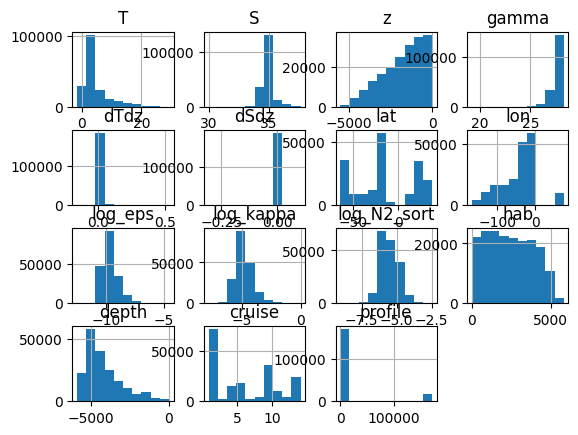

In [13]:
hist = df.hist(bins=10)

Conclusion: not a normal distribution for most parameters

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler_range = MinMaxScaler()
scaler_range.fit(X_train)
df_train_scaled_range = pd.DataFrame(scaler_range.transform(X_train))
df_test_scaled_range = pd.DataFrame(scaler_range.transform(X_test))

### Model configurations

In [11]:
activ = 'tanh'#'softsign'#
opt='Adam'
pat=30
n_epochs = 1000
val_split=.15
dropout_fraction=.2
n_units1 =35
n_units2 =35
# n_units3 =n_unit

batch_size = 16

### Define model

In [21]:
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

In [24]:
# number of input variables
n_var_in = X_train.shape[1]

8

In [49]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [55]:
y_pred = regr.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['log_kappa']) 

u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
score = 1 - (u/v)
print("R2 prediction score is:", score)

from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(y_test, y_pred))

from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

R2 prediction score is: log_kappa    0.634764
dtype: float64
MSE: 0.6816475327799285
MAE: 0.6976594764354485


NOTE: R2 score is negative, caution for non-linear regression...
R2 is defined on the fact that the total number of squares (total variation in data) of a fitted model is equal to explained sum of squares (variation in fitted model) plus residual sum of squares (variation not explained by fitted model).

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$ ($Eq_1$)

So, negative $R^2$ if residual sum of squares exceeds total number of squares. This is mathematically impossible, thus it means that $Eq_1$ does not hold true, so total number of squares is no longer the sum.

Reason for this could be that SS_tot is calculated using just the data, whereas SS_res depends on model predictions and the data. So eq1 holds for models trained on the same data, not for using test_data.

#### Hyperparameter tuning

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [ ]:
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}

gsc = GridSearchCV(
    regr,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)

best_params = grid_result.best_params_

best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= 5000, n_iter_no_change = 200
              )

scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

scores = cross_validate(best_mlp, X_train, y_train, cv=10, scoring=scoring,
                        return_train_score=True, return_estimator = True)

In [28]:
# define artificial neural network
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=8, kernel_initializer='normal', activation='relu'))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

#Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

#model.compile(
  #  optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
  #  loss=keras.losses.SparseCategoricalCrossentropy(),
  #  metrics=[keras.metrics.SparseCategoricalAccuracy()],
#)

# Fitting the ANN 
# Split train into validation data as well to monitor validation loss and accuracy
history = model.fit(X_train, y_train, validation_split=0.25, batch_size = 20, epochs = 30, verbose=1)

Epoch 1/30
5644/5644 [==============================] - 14s 2ms/step - loss: 1.4026 - val_loss: 0.3600
Epoch 2/30
5644/5644 [==============================] - 17s 3ms/step - loss: 0.3522 - val_loss: 0.3513
Epoch 3/30
5644/5644 [==============================] - 20s 4ms/step - loss: 0.3421 - val_loss: 0.3332
Epoch 4/30
5644/5644 [==============================] - 13s 2ms/step - loss: 0.3294 - val_loss: 0.3259
Epoch 5/30
5644/5644 [==============================] - 15s 3ms/step - loss: 0.3246 - val_loss: 0.3220
Epoch 6/30
5644/5644 [==============================] - 15s 3ms/step - loss: 0.3216 - val_loss: 0.3235
Epoch 7/30
5644/5644 [==============================] - 17s 3ms/step - loss: 0.3194 - val_loss: 0.3215
Epoch 8/30
5644/5644 [==============================] - 15s 3ms/step - loss: 0.3180 - val_loss: 0.3161
Epoch 9/30
5644/5644 [==============================] - 14s 2ms/step - loss: 0.3171 - val_loss: 0.3158
Epoch 10/30
5644/5644 [==============================] - 13s 2ms/step - l

In [30]:
y_pred = model.predict(X_test)

1176/1176 [==============================] - 2s 1ms/step


In [31]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [34]:
scores

0.31780746579170227

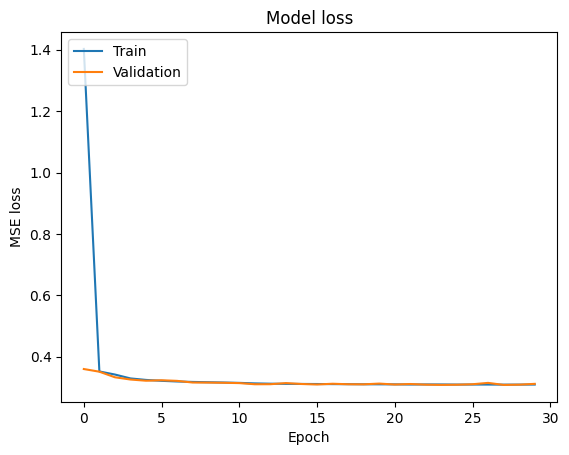

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()